# BatAnalysis Data Download Examples

This Notebook gives examples and techniques for downloading data from the HEASARC and quicklook archives using the BatAnalysis python package.

It assume that the BatAnalysis package has already been installed.  (See the `Example_Survey_Data_Analysis.ipynb` notebook in this directory for instructions.)

For this example, we will be using data from the giant outburst of Swift J0243.6+6124 in late 2017.
 https://swift.gsfc.nasa.gov/results/transients/weak/SwiftJ0243.6p6124/

## Setting up a download destination.
As a destination for your downloaded data, you can set a persistent data directory (if you haven't already):
```
ba.datadir('/local/bigdisk/batdata', mkdir=True, persistent=True)
```
or you can use a temporary directory just for this notebook run.  Set `always_use_tmp=True` below
if you have a persistent download directory but don't want to use it for this.

In [1]:
%matplotlib widget

always_use_tmp=True
tmp_download_dir="/tmp/batdata/download_examples"

# imports and setup.  See `Example_Survey_Data_Analysis.ipynb` notebook
import batanalysis as ba
import swiftbat
import swifttools

# Other libraries we will be using
try:
    import heasoftpy as hsp
except ImportError:
    print("heasoftpy (not installed) will be used in some of these examples, but is not needed to demonstrate downloads")
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from pathlib import Path
from astropy.io import fits
from astropy.time import Time
import datetime
import os

# Error out instead of stalling out while the heasoft waits for keyboard input
os.environ['HEADASNOQUERY']='1'

# One of the developers needs to work behind a proxy server
# everyone else can ignore this.
try:
    from dmptools import proxyfix
    proxyfix()
except ImportError:
    pass

if always_use_tmp or (ba.datadir().resolve() == Path('.').resolve()):
    ba.datadir(tmp_download_dir, mkdir=True)
    print(f"Setting data directory to {ba.datadir()}")
print(f"Data directory is {ba.datadir()}")

Setting data directory to /private/tmp/batdata/download_examples
Data directory is /private/tmp/batdata/download_examples


## Downloading 64 ms rate data for a single observation

A specific data type or types for a single observation ID (or 'OBSID') can be downloaded if you know that information.  How to find this information is discussed later on, but for now let's use the following example:

In [2]:
sourcename = "Swift J0243.6+6124"
obsid='00059158012'   # I know this is a good example observation 
match=['*brtms*']   # string found in filenames for Bat RaTe 64 MS lightcurve data

downloaded = ba.download_swiftdata(observations=[obsid], match=match, quiet=True)
downloaded

{'00059158012': {'obsid': '00059158012',
  'success': True,
  'obsoutdir': PosixPath('/private/tmp/batdata/download_examples/00059158012'),
  'quicklook': False,
  'data': Swift_Data(username='anonymous',obsid='00059158012',quicklook='False',auxil='True',bat='True',xrt='False',uvot='False',log='False',tdrss='True')}}

We just downloaded our selected file from the observation.  If you are re-running this notebook cell a second time and the `brtms` file is already in the local directory, then the code downloads the directory listing, looks at all filenames matching the `*brtms*` pattern, and discovers that the only one that matches is already on disk and refrains from downloading it.  It does produce a warning that says it is not overwriting.

The `downloaded` result is a `dict` indexed by OBSID, with each element itself a `dict`.  The `'data'` item of the per-`OBSID` `dict` is a table listing the files.

In [3]:
downloaded[obsid]['data']

00059158012/bat/rate,sw00059158012brtms.lc.gz,BAT rate lightcurve


And each row in the table has information about that file:

In [4]:
downloaded[obsid]['data'][0]

filename,sw00059158012brtms.lc.gz
path,00059158012/bat/rate
url,https://heasarc.gsfc.nasa.gov/FTP/swift/data/obs/2017_11/00059158012/bat/rate/sw00059158012brtms.lc.gz
quicklook,False
type,BAT rate lightcurve
size,881580
localpath,/private/tmp/batdata/download_examples/00059158012/bat/rate/sw00059158012brtms.lc.gz


The localpath tells you where the file is on your disk.  You can load the FITS file and plot the lightcurve data.  Because `%matplotlib widget` was given above, this plot is liive so you can zoom in on individual time ranges.  (The second plot is pre-zoomed.)

/private/tmp/batdata/download_examples/00059158012/bat/rate/sw00059158012brtms.lc.gz
ColDefs(
    name = 'TIME'; format = '1D'; unit = 's'
    name = 'COUNTS'; format = '4I'; unit = 'count'; bzero = 32768
)


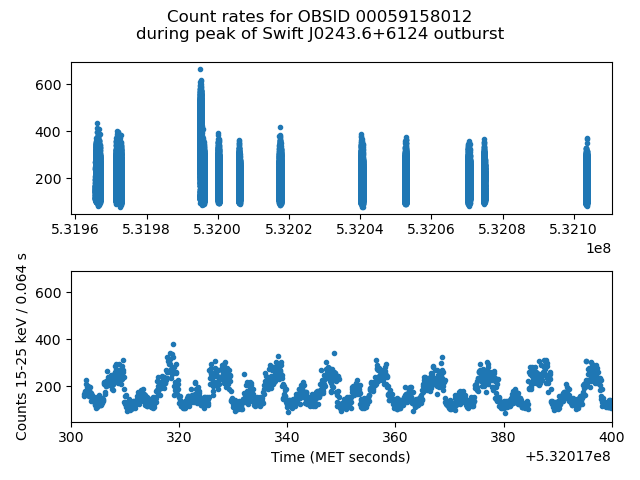

In [5]:
lcfile = downloaded[obsid]['data'][0].localpath
print(lcfile)
lcdata, lcheader = fits.getdata(lcfile, header=True)
print(lcdata.columns)
fig,axes = plt.subplots(nrows=2,ncols=1)
# The [:,0] selects the 15-25 keV energy bin
axes[0].plot(lcdata['TIME'], lcdata['COUNTS'][:,0],'.')
axes[1].plot(lcdata['TIME'], lcdata['COUNTS'][:,0],'.')
axes[1].set(xlim=[532017300, 532017400], xlabel='Time (MET seconds)', ylabel='Counts 15-25 keV / 0.064 s')
fig.suptitle(f"Count rates for OBSID {obsid}\nduring peak of {sourcename} outburst")
fig.tight_layout()


It is extremely rare that you can see count rate variations on the 64 ms timescale due to a non-GRB source, but Swift J0243.6+6124 was extremely bright and prominent with its ~10 second rotation period.  Let's expand the data analysis to cover the brightest few days of this source outburst.

## Getting data over a time interval, selecting for a source.

If you look at the [Swift/BAT scaled map lightcurve for this source](https://swift.gsfc.nasa.gov/results/transients/weak/SwiftJ0243.6p6124/), you can look at the lightcurve data in FITS or [text](https://swift.gsfc.nasa.gov/results/transients/weak/SwiftJ0243.6p6124.lc.txt) format.  The rate is highest on MJD 58064 = 2017-11-07.  Let's grab the data for 3 days around the peak, whenever Swift is pointed close enough to have at least 1000 cm^2 of exposure to the source.  Then let's string all the data together and run a frequency analysis.

We will use the `swiftbat` package for the exposure calculation, and `swifttools.swift_too.ObsQuery()` to get the list of pointings and their `OBSID`s.  (Another function `ba.from_heasarc()` would also be usable to find the OBSID's in this case, and there is an example in the  `Example_survey_data_analysis` notebook.)  See  **Using Quicklook Data** for more discussion of the difference between these functions.


To do this timing analysis right, you would have to also get the `'*sao.*'` file for each rate file and do a barycenter correction with the `barycorr` task, and also do the orbital correction of the neutron star around its companion.  However, the main timing effect on this source at this time is accretion-induced speed-up.

In [6]:
sourcename = "Swift J0243.6+6124"
source = swiftbat.source(sourcename)    # Can look up positions from Simbad, and can calculate exposure for a given pointing
timerange = [swiftbat.string2datetime(t) for t in ("MJD58063", "MJD58066")]
min_exposure_area = 1000     # cm^2 after cos adjust

table_stoo = swifttools.swift_too.ObsQuery(begin=timerange[0],end=timerange[1])
print(f"{len(table_stoo)} entries starting with")
for e in table_stoo[:5]:
    print(e)

565 entries starting with
+---------------------+---------------------+-------------+--------------------+--------------+--------------+
|          Begin Time |            End Time | Target Name | Observation Number | Exposure (s) | Slewtime (s) |
+---------------------+---------------------+-------------+--------------------+--------------+--------------+
| 2017-11-05 23:51:02 | 2017-11-06 00:13:00 |   Q1158+122 |        00085791005 |         1160 |          158 |
+---------------------+---------------------+-------------+--------------------+--------------+--------------+
+---------------------+---------------------+--------------------+--------------------+--------------+--------------+
|          Begin Time |            End Time |        Target Name | Observation Number | Exposure (s) | Slewtime (s) |
+---------------------+---------------------+--------------------+--------------------+--------------+--------------+
| 2017-11-06 00:13:02 | 2017-11-06 00:32:58 | Swift J1521.6+3203 

In [7]:
allobsids = []
obsids = []
for entry in table_stoo:
    if (entry.obsid not in allobsids):
        allobsids.append(entry.obsid)
        if source.exposure(ra=entry.ra, dec=entry.dec, roll=entry.roll)[0] > min_exposure_area:
            obsids.append(entry.obsid)
print(f"Out of {len(allobsids)} distinct OBSIDs, {len(obsids)} in FOV  to download.")
download_multi = ba.download_swiftdata(table_stoo, match=['*brtms*'], quiet=True)

Out of 310 distinct OBSIDs, 23 in FOV  to download.


In [8]:
lcsegments = []
# rate is rate over first 2 energy bins 15-50 keV
slice_ebins=slice(0,2)
timebin = 0.064
# Norm is mean-subtracted, stddev-scaled within a pointing
segdtype = np.dtype([('time', np.float64),('rate', np.int16),('norm', np.float32)])

for obsid, entry in download_multi.items():
    if not entry['success']:
        continue
    # if len(entry['data']) != 1:
    #     print(f"OBSID {obsid} has {len(entry['data'])} files")
    #     print(entry['data'])
    #     continue
    datafile = entry['data'][0].localpath
    obsdata = fits.getdata(datafile)
    # Split the data into arrays with no more than a second's gap
    splitlocs = np.argwhere(np.diff(obsdata['time']) > 1.1).ravel() + 1
    for segmentdata in np.split(obsdata, splitlocs):
        segment = np.empty(len(segmentdata), dtype=segdtype)
        segment['time'] = segmentdata['time']
        rate = np.sum(segmentdata['COUNTS'][:,slice_ebins], axis=1)
        segment['rate'] = rate
        segment['norm'] = (rate - np.mean(rate))/(0.001 + np.std(rate))
        lcsegments.append(segment)

# Sort by segment start time
lcsegments = sorted(lcsegments, key = lambda x:x['time'][0])

# Make sure the timebin is right
assert (0.9 * timebin) < np.median(np.diff(lcsegments[0]['time'])) < (1.1 * timebin)

# Use the segments to populate an array
t0 = lcsegments[0]['time'][0]
tmax = lcsegments[-1]['time'][-1]
ntimes = sp.fft.next_fast_len(int((tmax - t0)/timebin  + 10))    # 10 bins of slop, then round up to an FFT-friendly length
lcfull = np.zeros(ntimes)

for segment in lcsegments:
    n = len(segment)
    i0 = int((segment['time'][0] - t0)/timebin)
    lcfull[i0:i0+n] = segment['norm']

# Do the Fourier transform, and get the corresponding frequencies and powers
fnorm = sp.fft.rfft(lcfull, norm='forward')
freqs = sp.fft.rfftfreq(ntimes, timebin)
fpower = np.abs(fnorm)**2


freqmax = np.float64(0.10177253343038174) Hz, powermax = np.float64(0.0006053491348447017), grasslevel = np.float64(6.950893898376686e-07)


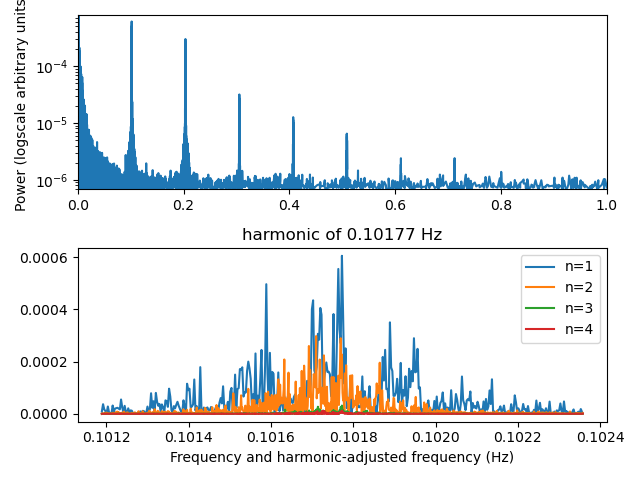

In [9]:
# Ignore periods below 10 minutes when looking for peak
zerof_ignore = int(ntimes/(600/0.064))
imax = zerof_ignore + np.argmax(fpower[zerof_ignore:])
freqmax = freqs[imax]
powermax = fpower[imax]
# Don't plot all points because that takes a long time
grasslevel = np.median(fpower) * 10
wplot = np.argwhere(fpower > grasslevel).ravel()

print(f"{freqmax = } Hz, {powermax = }, {grasslevel = }")

fig,axes = plt.subplots(nrows=2, ncols=1)
axes[0].plot(freqs[wplot], fpower[wplot])
axes[0].set(yscale='log', ylim=[grasslevel, powermax*1.3], xlim=[0,1], ylabel="Power (logscale arbitrary units)")
for harmonic in range(1,5):
    irange = ((imax + np.asarray([-200,201])) * harmonic).astype(int)
    axes[1].plot(freqs[irange[0]:irange[1]]/harmonic, fpower[irange[0]:irange[1]], label=f"n={harmonic}")
axes[1].legend() #
axes[1].set(title=f"harmonic of {freqmax:.5f} Hz", xlabel="Frequency and harmonic-adjusted frequency (Hz)")
fig.tight_layout()

Further frequency analysis is left to the reader.

## Using Quicklook Data

After data is received from the spacecraft, it is processed on the ground, even if further observations are planned using the same `OBSID`.  Only after all the data for an `OBSID` has been received is the final processing done and, on about a 1-week timescale, the data is sent to the HEASARC for permanent archiving.  If you need the recent partially-processed data, you can get it from one of the 'quicklook' servers instead of the HEASARC.

The `ba.from_heasarc()` function only returns information about `OBSID`s that have been delivered to HEASARC.  Therefore you want to use `swifttools.swift_too.ObsQuery()` to get more recent `OBSID`s.  `ObsQuery()` gives a record for each pointing rather than for each `OBSID`, so there is duplication in the table, but `ba.download_swiftdata()` ignores the duplicates for efficiency.  The calling sequence and output format are also slightly different between the two functions.

`ba.download_swiftdata()` loads HEASARC permanent data if it is available, and quicklook data otherwise.  Quicklook data is marked by a `.quicklook` file in the `OBSID` directory and reloaded each time it is requested.

For this example, we will get the 'BAT 1 s count rates' which are generated by the BAT hardware.  For simplicity of this demonstration, we will take data from the past day and only plot a few hundred seconds from one of the files.  However a full day's data is downloaded.

Different runs of these notebook cells will produce different results due to the dynamic nature of the data.


In [10]:

utcnow = datetime.datetime.now(tz=datetime.timezone.utc)
table_stoo = swifttools.swift_too.ObsQuery(begin=utcnow-datetime.timedelta(days=1),end=utcnow)

download_day1s = ba.download_swiftdata(table_stoo, match=['*brt1s*'], quiet=True)

for obsid, entry in download_day1s.items():
    if not entry['success']:
        continue
    datafile = entry['data'][0].localpath
    obsdata = fits.getdata(datafile)
    # Split the data into arrays with no more than a second's gap
    splitlocs = np.argwhere(np.diff(obsdata['time']) > 1.1).ravel() + 1
    for segmentdata in np.split(obsdata, splitlocs):
        break
    break

print(entry['data'][0])

+-----------+------------------------------------------------------------------------+
| Parameter |                                                                  Value |
+-----------+------------------------------------------------------------------------+
|  filename |                                               sw00031702076brt1s.lc.gz |
|      path |                                                   00031702076/bat/rate |
|       url | https://swift.gsfc.nasa.gov/data/swift/sw00031702076.006/bat/rate/sw00 |
|           |                                                   031702076brt1s.lc.gz |
| quicklook |                                                                   True |
|      type |                                                    BAT rate lightcurve |
|      size |                                                                  12751 |
| localpath | /private/tmp/batdata/download_examples/00031702076/bat/rate/sw00031702 |
|           |                              

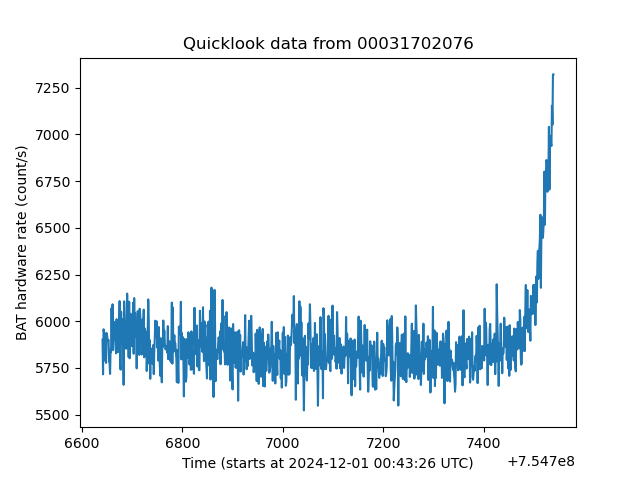

In [11]:

plt.figure()
plt.plot(segmentdata['TIME'],segmentdata['COUNTS'])
tstart = swiftbat.met2datetime(segmentdata['TIME'][0], correct=True)
plt.gca().set(xlabel=f"Time (starts at {tstart:%Y-%m-%d %H:%M:%S} UTC)", title=f"Quicklook data from {obsid}", ylabel="BAT hardware rate (count/s)")
None

## Remote directory listing and structure

What if you want to know what files are available during an observation?  You can use `download_swiftdata()` but tell it to not fetch the data. If you do not give it any match strings, it will find all files for the specified instruments and directories.

In [12]:
# What if you want a directory listing of the remote archive, but don't need the actual files yet?
# Don't fetch, don't give patterns to match, and look at all types of data
dirlist = ba.download_swiftdata(observations=[obsid], fetch=False, bat=True, xrt=True, uvot=True, auxil=True, log=True, tdrss=True)
dirlist[obsid]['data']

00031702076/auxil,SWIFT_TLE_ARCHIVE.txt.24333.63568481.gz,Auxillary TLE file
'',sw00031702076pat.fits.gz,Auxillary attitude file
'',sw00031702076pjb.par.gz,Auxillary file
'',sw00031702076pob.cat.gz,Auxillary catalog
'',sw00031702076ppr.par.gz,Auxillary file
'',sw00031702076s.mkf.gz,Auxillary file
'',sw00031702076sao.fits.gz,Auxillary file
'',sw00031702076sat.fits.gz,Auxillary attitude file
'',sw00031702076sen.hk.gz,Auxillary housekeeping
'',sw00031702076sti.fits.gz,Auxillary file
'',sw00031702076uat.fits.gz,Auxillary attitude file


That's a lot of files!  You can see why restricting the files you download with the `match=` patterns makes sense if you don't have infinite bandwidth and diskspace.  What are all these files and which ones do you need?  That depends on what kind of analysis you are working on, and what questions you are asking.

A good overview of the filestructure, with a terse description of each type, is in the [Guide To the Swift Archive](https://swift.gsfc.nasa.gov/archive/archiveguide1_v2_2_apr2018.pdf).

# TDRSS (Subthreshold TTE) Data

And this is not even all of the data for a given time interval.  These are the data products associated with an `OBSID`, covering the set of time intervals (typically on a ~90 minute/1 orbit spacing) over the course of a day when the spacecraft is pointing in the same direction.  There is another set of data, which is typically stored in the `tdrss` directory, that is associated with a given trigger number.  This is where event-by-event data (also known as Time Tagged Events: TTE) is found if it is not associated with a GRB.

Automated access to TDRSS data including TTE is under development and has limited capabilities. If the capability to query TDRSS data with BatAnalysis is not sufficient for now, data can be manually downloaded from the HEASARC if you know the month and trigger number: e.g. `https://heasarc.gsfc.nasa.gov/FTP/swift/data/tdrss/2023_06/01171731000/`.  Quicklook recent `tdrss` data is in (https://swift.gsfc.nasa.gov/data/swift/qltdrss/)

The main limitation has to do with querying and downloading TDRSS data if one knows the trigger number. As such, the code below will not find the relevant data (which can be accessed at the link above):

In [13]:
# The following does not work
trignum = '1771731'
download_tdrss = ba.download_swift_trigger_data(trignum, fetch=False)
print(download_tdrss.keys())


dict_keys([])


We can however, query TDRSS data based on either trigger time or a time range. For example, we can query data based on a known trigger time of 2024-07-29T12:05:16 which is the time of a flare from EXO 0748-676 (see the associated jupyter notebook where we analyze this subthreshold trigger data). We set `fetch=False` here so we can query the data without downloading it directly. 

We will see that the function finds two sets of subthreshold trigger data and also tries to find an associated `OBSID` that is within 300 seconds in time, by default. In the analysis of the subthreshold TTE data that was just found, we need calibration data from the nearest observation `OBSID` in time which is why in the EXO 0748-676 jupyter notebook we set `timewindow=400` to download this extra necessary dataset to properly analyze the TTE data.

In [14]:
t=Time("2024-07-29T12:05:16")
result = ba.download_swift_trigger_data(triggertime=t.datetime, fetch=False)

for i in result.keys():
    print(result[i])

[Swift_Data(username='anonymous',obsid='01245445000',quicklook='False',auxil='True',subthresh='True',itsdc='False'), Swift_Data(username='anonymous',obsid='03104687002',quicklook='False',auxil='True',bat='True')]
[Swift_Data(username='anonymous',obsid='01245446000',quicklook='False',auxil='True',subthresh='True',itsdc='False')]


/Users/tparsota/Library/CloudStorage/Box-Box/BatAnalysis/batanalysis/batlib.py:1908: UserWarning: The subthreshold trigger 1245446 has a nearest hk/auxil observation ID that is >300 s away. ObsID 03104687002 is  318.00000394192057 s away.


We can also query TDRSS data for a range of dates such as below. There are lots of data mostly due to noise however, with this capability users can search for subthreshold transients from sources that they may be interested in by filtering the queried data for those that were taken while the source was in the BAT field of view. 

In [15]:
result = ba.download_swift_trigger_data(time="2024-01-01T00:00:00 .. 2024-01-01T01:00:00", fetch=False)
print(result)

/Users/tparsota/Library/CloudStorage/Box-Box/BatAnalysis/batanalysis/batlib.py:1908: UserWarning: The subthreshold trigger 1205633 has a nearest hk/auxil observation ID that is >300 s away. ObsID 00016465001 is  325.0000024486329 s away.
/Users/tparsota/Library/CloudStorage/Box-Box/BatAnalysis/batanalysis/batlib.py:1908: UserWarning: The subthreshold trigger 1205605 has a nearest hk/auxil observation ID that is >300 s away. ObsID 00016413012 is  549.9999966329218 s away.
/Users/tparsota/Library/CloudStorage/Box-Box/BatAnalysis/batanalysis/batlib.py:1908: UserWarning: The subthreshold trigger 1205606 has a nearest hk/auxil observation ID that is >300 s away. ObsID 00016413012 is  650.9999982403846 s away.
/Users/tparsota/Library/CloudStorage/Box-Box/BatAnalysis/batanalysis/batlib.py:1908: UserWarning: The subthreshold trigger 1205607 has a nearest hk/auxil observation ID that is >300 s away. ObsID 00016413012 is  1063.9999986017378 s away.
/Users/tparsota/Library/CloudStorage/Box-Box/Ba

KeyboardInterrupt: 